In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import ast
df=pd.read_csv("CAX_LogFacies_Train_File.csv" )
#test=pd.read_csv("CAX_LogFacies_Test_File.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400000 entries, 0 to 4399999
Data columns (total 4 columns):
row_id     int64
well_id    int64
GR         float64
label      int64
dtypes: float64(1), int64(3)
memory usage: 134.3 MB


## Subsampleo con reglas de la clase mayoritaria por time series

In [2]:
df=pd.read_csv("CAX_LogFacies_Train_File.csv" )

pivoted = pd.pivot_table(data = df,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR")
pivoted.columns = ["label0","label1","label2","label3","label4"]
n = 1100
a = 0.11
b = 0.45
dfsample = pivoted.query(f"label0<{b}*{n} and label1>{a}*{n} and label2>{a}*{n} and label3>{a}*{n} and label4>{a}*{n}").index
df = df[df["well_id"].isin(dfsample)]
names  = ["Serrated","Symmetrical", "Cylindrical" ,  "Funnel" ,    "Bell"] # Nombramiento de las labels
for n,i in enumerate(names):
    df.loc[df["label"] ==n,"name"] = i

# 52 series temporales

In [242]:
df

,row_id,well_id,GR,label,name
8800,0,8,117.230000,0,Serrated
8801,1,8,116.709108,0,Serrated
8802,2,8,126.548217,0,Serrated
8803,3,8,121.177325,0,Serrated
8804,4,8,109.506433,0,Serrated
...,...,...,...,...,...
4365895,1095,3968,125.715405,0,Serrated
4365896,1096,3968,127.309054,0,Serrated
4365897,1097,3968,120.602702,0,Serrated
4365898,1098,3968,135.116351,0,Serrated


In [ ]:
example = []
for i in range(100):
    example.append(pd.DataFrame(interlabel[4][i])["GR_mnorm"].reset_index(drop=True))

## Comparación de distintos graficos para verificar si se mantienen las caracteristicas del dataset completo

## Distribucion total de las clases por time series verticalmente


Text(0.5, 0, 'Wells')

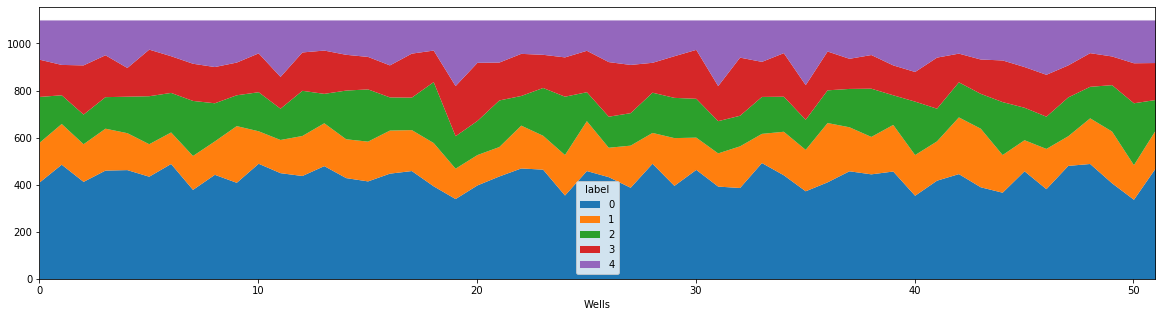

In [266]:
pivoted = pd.pivot_table(data = df,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR")

pd.pivot_table(data = df,columns  = "label",aggfunc='count' ,index = 'well_id',values = "GR").reset_index(drop =True).plot(kind = 'area',figsize=(20,5),linewidth = 0.01,)
plt.xlabel("Wells")
plt.xlabel("Wells")


## Proproción de las clases 

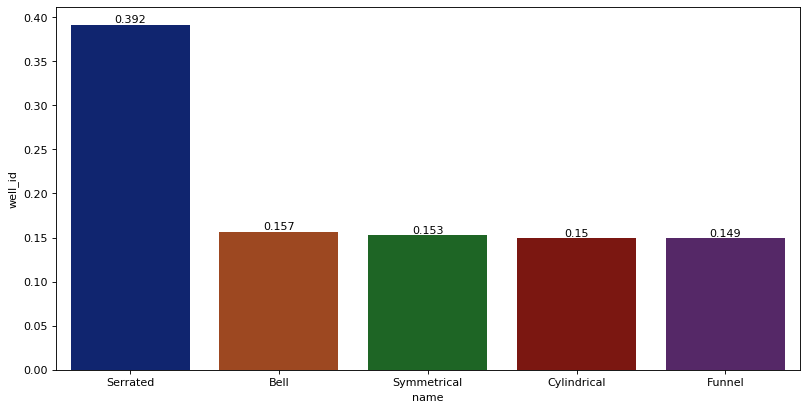

<Figure size 1080x720 with 0 Axes>

In [267]:
# sns.set_style("whitegrid")

from matplotlib.pyplot import figure
figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')

data = (df.groupby(['name']).count()/df.count())[["well_id"]]
data.sort_values("well_id", ascending = False, inplace= True)
graph = sns.barplot(x=data.index,y='well_id', data=data, palette='dark',label="name")

plt.figure(figsize=(15,10))
for p in graph.patches:
        graph.annotate(f'{p.get_height().round(3)}', (p.get_x()+0.4, p.get_height()),
                    ha='center', va='bottom',
                    color= 'black')


# Probabilidades de clase por a lo largo del time series en areas

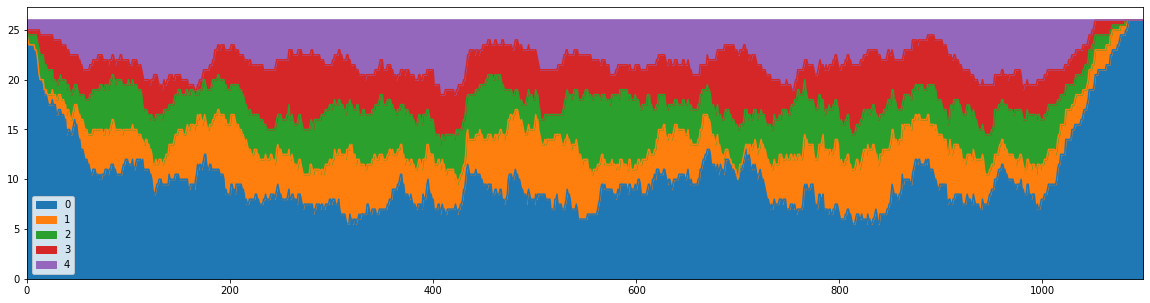

In [268]:
pivoted = pd.pivot_table(data = df,columns  = "well_id",aggfunc='mean' ,index = 'row_id',values = "label")
z=pd.DataFrame()
for i in range(5):
    z=z.append(pivoted[pivoted == i].count(axis=1),ignore_index =True)
z = z.transpose()
(z/2).plot(kind="area",figsize=(20,5))

# Probabilidades de clase por a lo largo del time series en areas


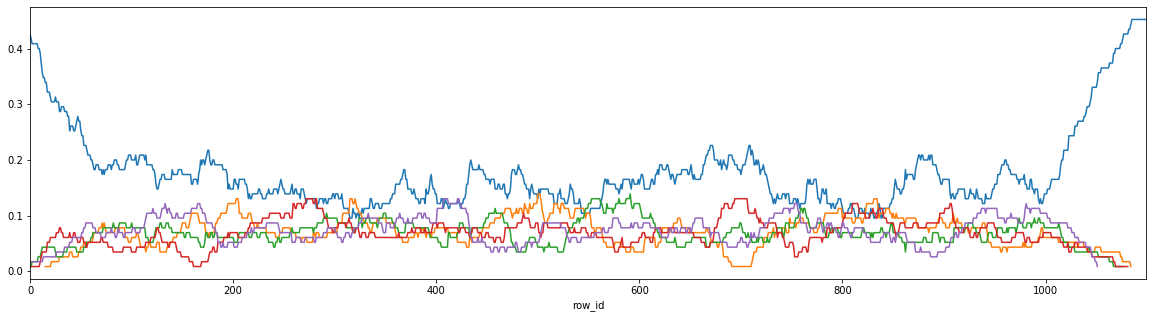

In [269]:
pivoted = pd.pivot_table(data = df.query("label == 0"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = df.query("label == 1"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = df.query("label == 2"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = df.query("label == 3"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot(figsize=(20,5))
pivoted = pd.pivot_table(data = df.query("label == 4"),columns  = "well_id",aggfunc='count' ,index = 'row_id',values = "label")
(pivoted.count(axis=1)/115).plot()

## Distribucion de clases por pozo. Vemos que la clase mayoritaria es un 50% en casi todos los pozos y la distribucion de las demas es casi la misma

## Feature Engineering
#### Se propuso Normalizar 
#### Calculo de ventanas temporales y regresiones localizadas

In [58]:
def huberlambda(x,y):
    X = np.array(range(x)).reshape(-1,1)
    huber = HuberRegressor().fit(X, y)
    return huber



df['GR_mnorm'] = df.groupby('well_id')['GR'].transform(lambda x: (x-x.min())/(x.max()-x.min()))
df["1huber"] = df.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: huberlambda(20, y).coef_,'raw=False').reset_index(0,drop=True)
df["2huber"] = df.groupby('well_id')['GR_mnorm'].rolling(40,center=True).apply(lambda y: huberlambda(40, y).coef_,'raw=False').reset_index(0,drop=True)


# df["0polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(20,center=True).apply(lambda y: np.polyfit(np.array(range(20)), y, 2)[0],'raw=False').reset_index(0,drop=True)
df["1polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(30,center=True).apply(lambda y: np.polyfit(np.array(range(30)), y, 2)[1],'raw=False').reset_index(0,drop=True)
# df["2polyfit"] = df.groupby('well_id')['GR_mnorm'].rolling(50,center=True).apply(lambda y: np.polyfit(np.array(range(50)), y, 2)[2],'raw=False').reset_index(0,drop=True)

# df['20rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(20,win_type = "barthann",min_periods=1,center= True).mean().reset_index(0,drop=True)
df['30rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)
# df['40rolling_mean'] = df.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann ",min_periods=1,center= True).mean().reset_index(0,drop=True)



df['30rolling_std'] = df.groupby('well_id')['GR_mnorm'].rolling(30,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
# df['40rolling_std'] = df.groupby('well_id')['GR_mnorm'].rolling(40,win_type = "barthann",min_periods=1,center= True).std().reset_index(0,drop=True)
df=df.fillna(0)

## Se grafico el pozo 22 junto con el suavizado de medias de ventana 5 y la ventana de variacion

## Desfajse de propiedaes temporales de veciones cercanos

In [59]:
def transform_shfit(df,k,GR):
    for i in range(1,k):
        a = i*2
        df["- "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(a))
        df["+ "+GR+str(a)] =df.groupby('well_id')[GR].apply(lambda x: x.shift(-a))
    df=df.fillna(0)
    return df

df=transform_shfit(df,10,"30rolling_mean")
df=transform_shfit(df,10,"1huber")
df=transform_shfit(df,10,"GR_mnorm")
df=df.fillna(0)


## Ejemplo de regresiones localizadas lineales , Comparacion regresion robusta VS no robusta

Text(0.5, 1.0, 'Pozo 8: Ejemplo de rectas Huber')

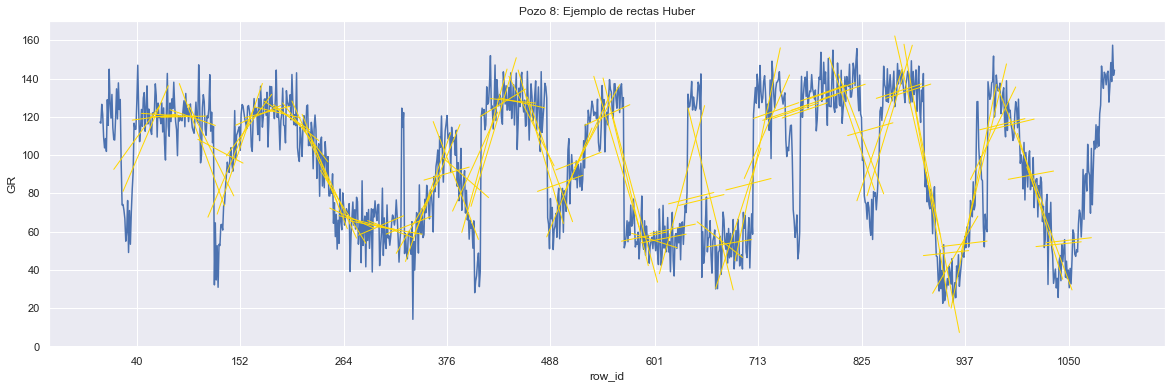

In [233]:
def huberlambda(x,y):
    x = x.values.reshape(-1,1)
    interval = range(y)
    huber = HuberRegressor().fit(x, interval)
    return huber
test = df.iloc[:1100].reset_index()
fig = plt.figure(figsize=(20, 6))
plt.plot(test["GR"])

for i in np.linspace(40,1050,100, dtype=int):
    distance = 50
    ubic = i
   
    x = test.iloc[int(ubic-distance/2):int(ubic+distance/2)].index.values.reshape(-1,1)
    y = test.iloc[int(ubic-distance/2):int(ubic+distance/2)]["GR"]
#     lr = LinearRegression()
#     lr.fit(x,y.values.reshape(-1,1))
#     lcoef_ = lr.coef_ *x + lr.intercept_
#     plt.plot( x ,lcoef_, color = "g",linewidth="1")
    
    hb = HuberRegressor(epsilon = 1.5)
    hb.fit(x,y)
    hbcoef_ = hb.coef_ *x + hb.intercept_
    plt.plot( x, hbcoef_,color = "gold",linewidth="1", label = "Rectas Huber")
plt.xticks(np.linspace(40,1050,10, dtype=int));
plt.xlabel("row_id")
plt.ylabel("GR")
# plt.legend()
plt.title("Pozo 8: Ejemplo de rectas Huber")
# plt.plot(range(200,300),range(200,300), color = "g")


[0 1 3 4 2]


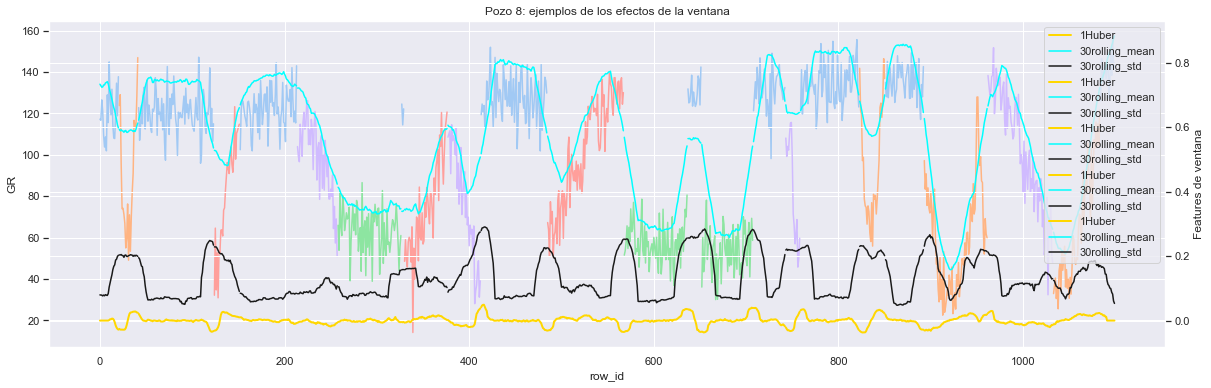

In [235]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i)).reset_index()
    labels= df["label"].unique()
    print(labels)
    palette1 = sns.color_palette('pastel', len(labels))
    palette2 = sns.color_palette('deep', len(labels))

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copy = df.copy()
        copy.loc[copy['label']!= l,[ "GR","1huber","30rolling_mean","30rolling_std" ]] = np.nan
        axes1.plot(copy["GR"], color=palette1[l])
        axes2.plot(copy["1huber"], color="gold",linewidth = "2",label = "1Huber") 
        axes2.plot(copy["30rolling_mean"], color="cyan", label = "30rolling_mean") 
        axes2.plot(copy["30rolling_std"], color="k", label = "30rolling_std") 
    axes1.set_xlabel('row_id')
    axes1.set_ylabel('GR')
    axes2.set_ylabel('Features de ventana')
    axes1.set_title("Pozo 8: ejemplos de los efectos de la ventana")

    plt.legend()

plot_multicolored_line(df ,8)


## Nos aseguramos de que el split sea con pozos enteros en un 30%.

In [60]:
test_series = pd.DataFrame(df["well_id"].unique().tolist(), columns = ["well_id"]).sample(frac = 0.3, random_state = 0)
train = df[(~df["well_id"].isin(test_series["well_id"]))]
test = df[(df["well_id"].isin(test_series["well_id"]))]
y_train = train["label"]
y_test = test["label"]
x_train = train.drop(["label","name"],axis=1,errors = 'ignore' )
x_test = test.drop(["label","name"],axis=1,errors = 'ignore' )

# y=df["label"]
# x=df.drop(["label","name"],axis=1)
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3,shuffle = False )

## Hiperoptimizacion Bayesiana

In [75]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from timeit import default_timer as timer
import ml_metrics

tpe_algorithm = tpe.suggest
def acc_model(params):
    clf = RandomForestClassifier(**params)
    clf.fit(x_train, y_train)
#     return clf.score(x_test, y_test)
    return cross_val_score(clf, x_train, y_train,cv = 3).mean()
best = 0
param_space = {
    'max_depth': hp.choice('max_depth', range(20,200)),
    'max_features': hp.choice('max_features', np.arange(0.4,1,0.1)),
    'n_estimators': hp.choice('n_estimators', range(50,400)),
    'criterion': hp.choice('criterion', ["gini", "entropy"]),
    'bootstrap': hp.choice('bootstrap', [False, True])
}
def f(params):
    start = timer()
    global best 
    acc = acc_model(params)
    run_time = timer() - start
    if acc > best:
        best = acc
        print("NEW BEST")
    of_connection = open("algo.csv", 'a')
    writer = csv.writer(of_connection)
    writer.writerow([-acc, params, run_time])
    of_connection.close()
    print ( best, params)
    return {'loss': -acc, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, param_space, algo=tpe.suggest, max_evals=100, trials=trials)

print ('best:')
print (best)

NEW BEST                                                                                                               
new best:                                                                                                              
0.8526136363636364                                                                                                     
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 29, 'max_features': 0.7999999999999999, 'n_estimators': 120}    
NEW BEST                                                                                                               
new best:                                                                                                              
0.8651704545454545                                                                                                     
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 79, 'max_features': 0.6, 'n_estimators': 197}                   
new best:                               

In [82]:
bayes_trials_results  = sorted(trials.results, key = lambda x: x['loss'])
bayes_trials_results [:3]
import pickle
pickle.dump(trials, open('trials.pkl', 'wb'))

In [161]:
results = pd.read_csv('algo.csv')
results.columns = ["loss","params","time"]
# Sort with best scores on top and reset index for slicing
results.sort_values(by = "loss", ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)
best_params = results["params"][0]
best_params = ast.literal_eval(best_params)
from pandas import option_context
with option_context('display.max_colwidth', 400):
    display(results.head())

,loss,params,time
0,-0.872614,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 156, 'max_features': 0.4, 'n_estimators': 288}",277.442666
1,-0.872500,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 190, 'max_features': 0.4, 'n_estimators': 249}",238.955202
2,-0.872159,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 52, 'max_features': 0.4, 'n_estimators': 168}",287.184178
3,-0.872045,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 69, 'max_features': 0.4, 'n_estimators': 254}",245.277918
4,-0.871932,"{'bootstrap': True, 'criterion': 'gini', 'max_depth': 69, 'max_features': 0.4, 'n_estimators': 281}",297.326860


In [189]:
best_params

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 156,
 'max_features': 0.4,
 'n_estimators': 288}

In [160]:
# model = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
#                        max_depth=100, max_features='auto', max_leaf_nodes=None,
#                        min_impurity_decrease=0.0, min_impurity_split=None,
#                        min_samples_leaf=2, min_samples_split=10,
#                        min_weight_fraction_leaf=0.0, n_estimators=500,
#                        n_jobs=None, oob_score=False, random_state=None,
#                        verbose=0, warm_start=False)

model = RandomForestClassifier(**best_params)
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=156, max_features=0.4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=288,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Score evaluado sobre el mismo training 

In [162]:
predictions = model.predict(x_test)
model.score(x_train, y_train)

1.0

# Score evaluado sobre el testting

In [166]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))
model.score(x_test, y_test)

[[6649   75    0  111  119]
 [ 165 2017  164  181  200]
 [   1  109 2255   51   32]
 [ 213  181   66 2137   60]
 [ 306  125   36   82 2265]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      6954
           1       0.80      0.74      0.77      2727
           2       0.89      0.92      0.91      2448
           3       0.83      0.80      0.82      2657
           4       0.85      0.80      0.83      2814

    accuracy                           0.87     17600
   macro avg       0.86      0.85      0.85     17600
weighted avg       0.87      0.87      0.87     17600



0.870625

# Grafico de predicciones comparando resultados verdadero

In [176]:

test = x_test.copy()
test["predictions"] = predictions
test.loc[test["predictions"]== 1, "predictions"] = 2
test["label"] = y_test
test.loc[test["predictions"]>0,"predictionsuni"] = 1
test.loc[test["label"]>0,"labeluni"] = 1

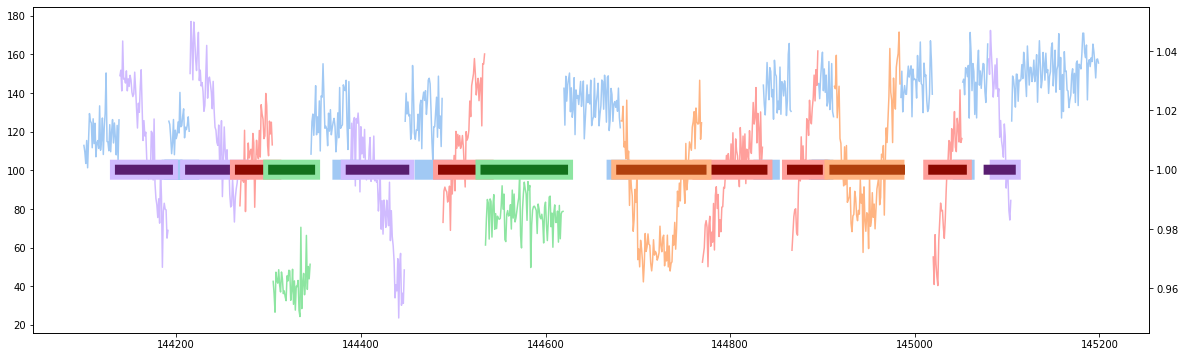

In [180]:
def plot_multicolored_line(df, i):
    df = df.query("well_id == '{}'".format(i))
    labels= df["label"].unique()
    palette1 = sns.color_palette('pastel', len(labels))
    palette2 = sns.color_palette('dark', len(labels))

    fig = plt.figure(figsize=(20, 6))
    axes1 = fig.add_subplot(111)
    axes2 = axes1.twinx()   # mirror them
    for l in list(labels):
        copydf = df.copy()
        copydf.loc[copydf['label']!= l, ["GR","labeluni","predictionsuni"]] = np.nan
        axes1.plot(copydf["GR"], color=palette1[l])
        axes2.plot(copydf["predictionsuni"], color=palette1[l],linewidth = 20)
        axes2.plot(copydf["labeluni"], color=palette2[l],linewidth = 10)
plot_multicolored_line(test ,131)


## Importancia de las variables junto con su variacion en el random forest:

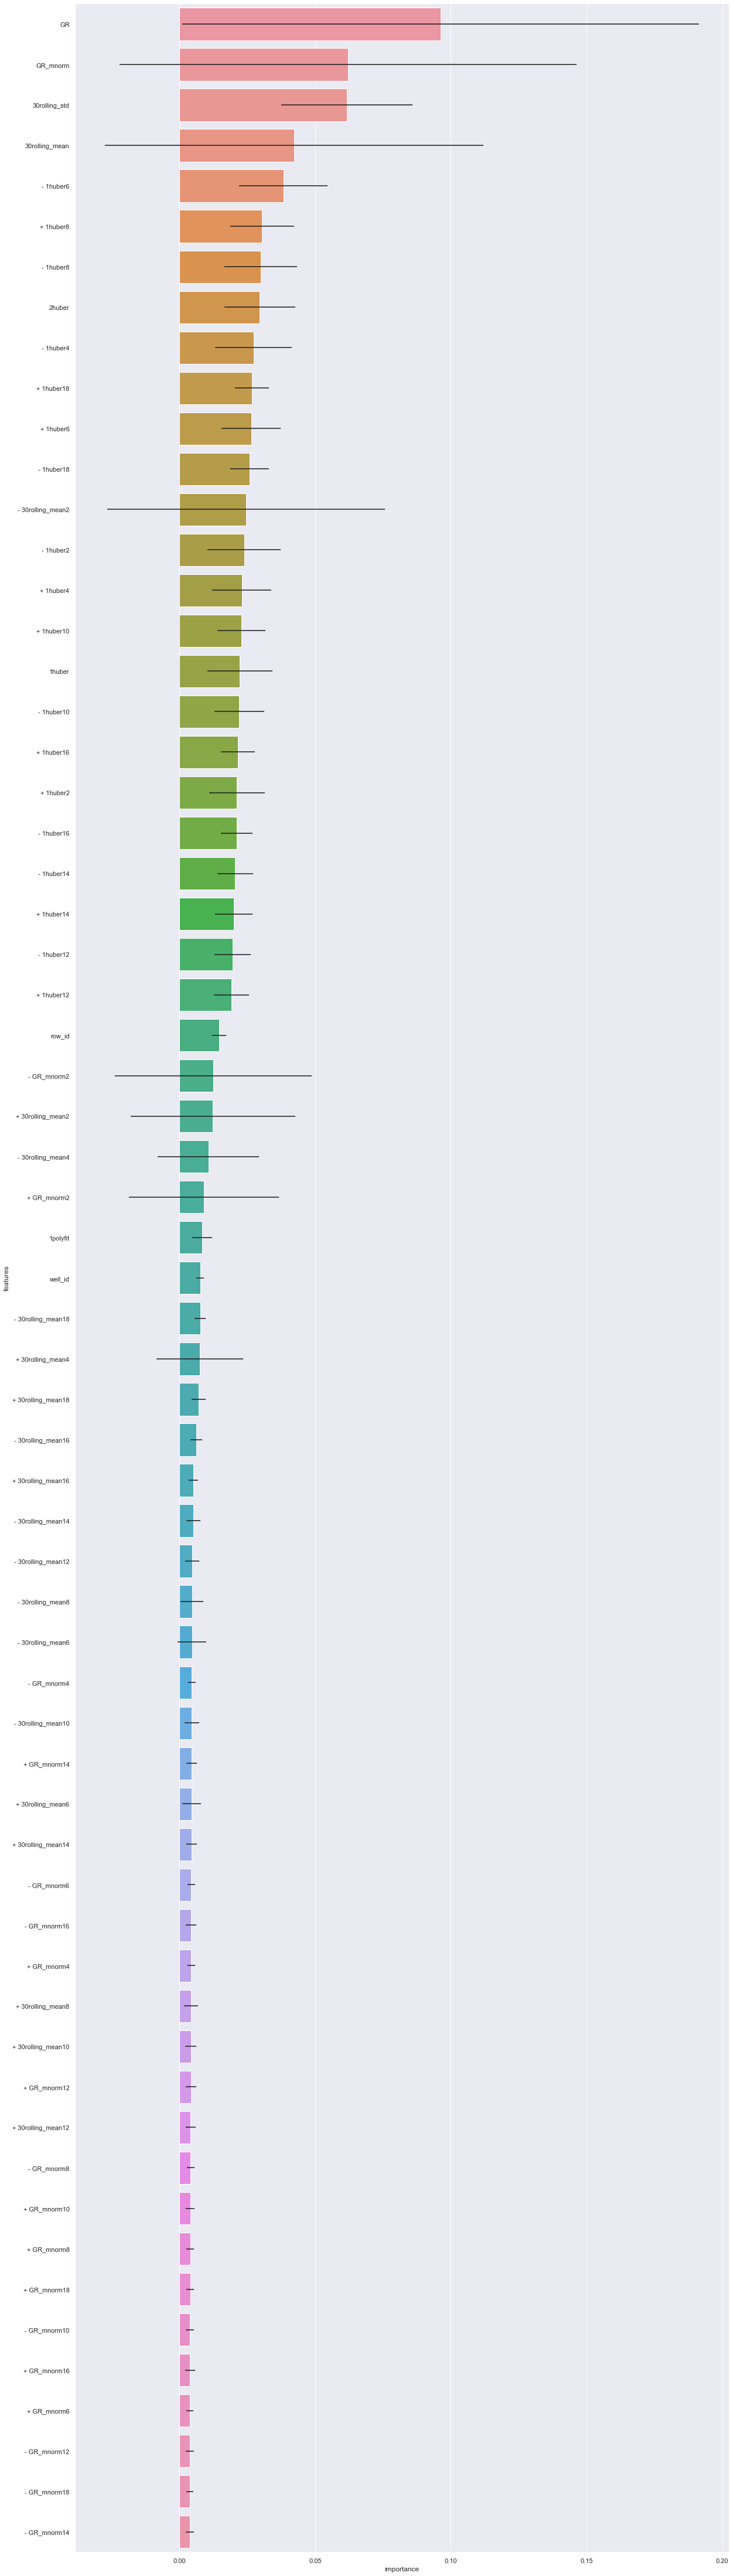

In [184]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,80)})
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
importance = model.feature_importances_
features = x_train.columns

feature_importance = pd.DataFrame()
feature_importance["importance"] = importance
feature_importance["std"] = std
feature_importance["features"] = features
feature_importance.sort_values("importance",ascending=False, inplace=True)
feature_importance.reset_index(drop = True , inplace = True)
sns.barplot(data =feature_importance , x ="importance", y ="features",xerr=feature_importance["std"])

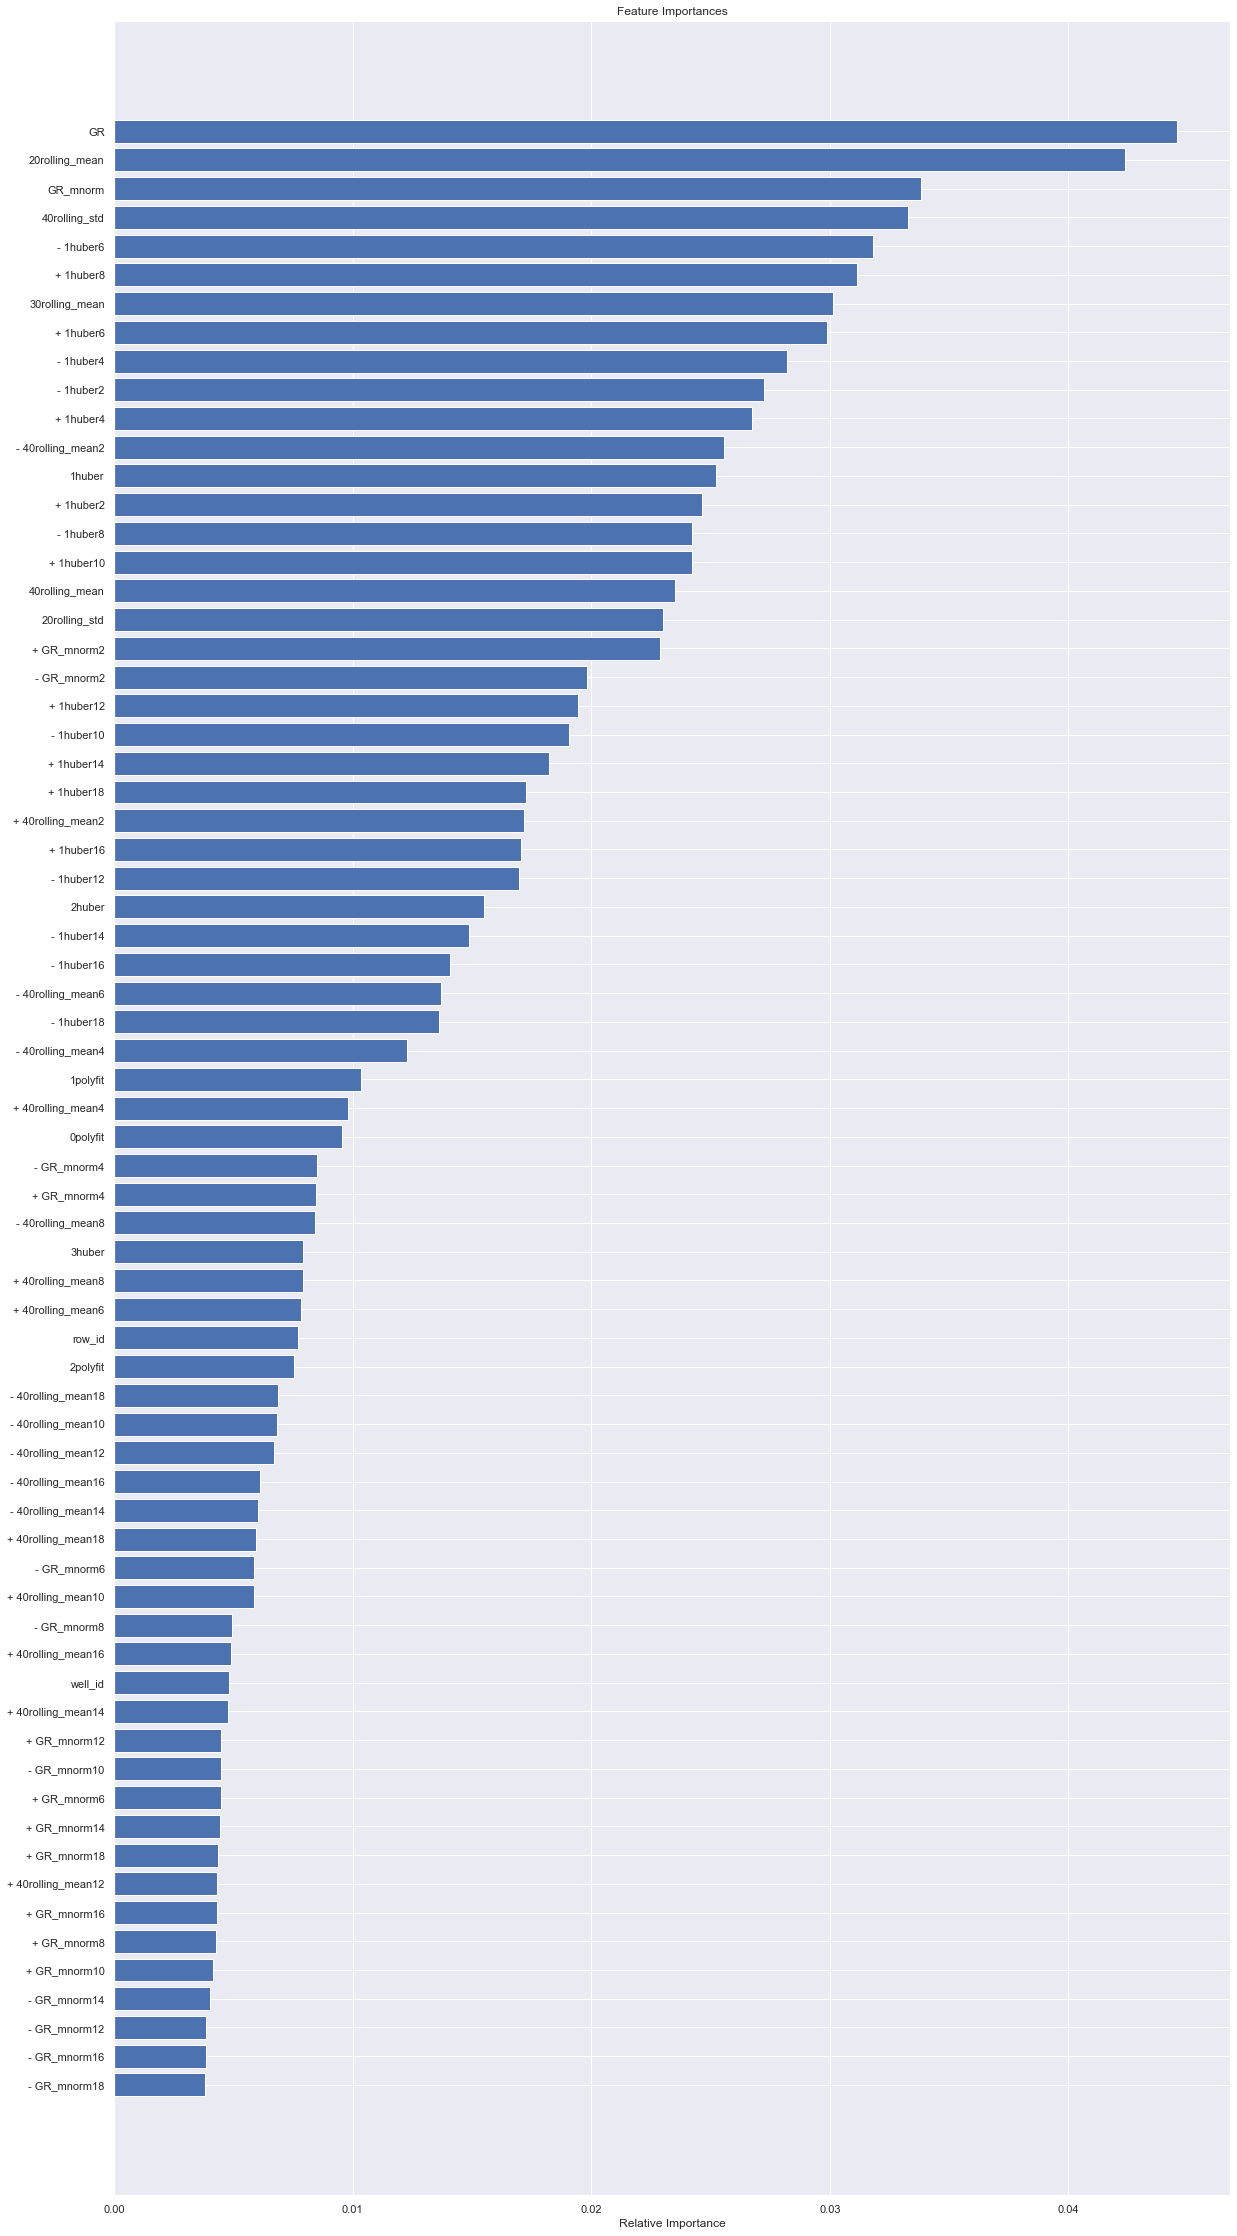

In [101]:
features = x_test.columns
importances = model.feature_importances_
indices = np.argsort(importances)

fig = plt.figure(figsize=(20, 40))
ax = fig.add_subplot(111)
plt.title('Feature Importances')
ax.barh(range(len(indices)), importances[indices], color='b')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Planteo de Random forest optimizacion no utilizado

In [ ]:
forest=model
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [ ]:
'''rf = RandomForestClassifier()
gs = GridSearchCV(rf,{ 'max_depth': np.arange(20,51,5),
                    'n_estimators':np.arange(400,1500,150),
                    'max_features':np.arange(0.39,0.91,0.05)}
                      ,verbose=2,n_jobs=-1, 
                        error_score='raise')

gs.fit(x_train,y_train.values.ravel())
gs.best_score_, gs.best_params_'''
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,6]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

In [ ]:
rf_random.best_estimator_